# Exercise: Application of Machine Learning in Real Estate Price Prediction

## Objective:
Understand and apply machine learning techniques to predict housing prices using the Kaggle dataset.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline   
import pickle
import os
import warnings
from scipy.stats import skew, norm
from scipy import stats

%matplotlib inline
%load_ext autoreload

In [2]:
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

In [3]:
# Set the option to display all rows
pd.set_option('display.max_rows', None)

# Set the option to display all columns
pd.set_option('display.max_columns', None)

In [4]:
df = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\train.csv')
df_test = pd.read_csv(r'C:\Users\jorda\Documents\studies\DScourse\CourseMaterials\Data\home-data-for-ml-course\test.csv')

df_orig = df.copy()
df_test_orig = df_test.copy()

### Functions and Classes Used:

In [5]:
# Divide the data into numerical and categorical features
def divide_features(df):
    numerical_features = df.select_dtypes(include=[np.number])
    categorical_features = df.select_dtypes(include=[object])
    return numerical_features, categorical_features

def convert_to_columns_list(df):
    columns_list = df.columns.tolist()
    return columns_list

# Display a subplots of the numerical features.
# Two subplots are created for each feature. The first subplot is a histogram of the feature with 100 bins and the second subplot is a scatter plot of the feature vs the target variable.
# The scatter plot helps to identify outliers.
def display_numerical_features(df, features, target):
    for feature in features:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
        sns.distplot(df[feature], fit=norm, ax=axs[0], bins=100)
        sns.scatterplot(x=feature, y=target, data=df, ax=axs[1])
        plt.show()

# Display a subplots of the categorical features.
# Two subplots are created for each feature. The first subplot is a count plot of the feature and the second subplot is a box plot of the feature vs the target variable.
# The box plot helps to identify outliers.
def display_categorical_features(df, features, target):
    for feature in features:
        fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
        sns.countplot(x=feature, data=df, ax=axs[0])
        sns.boxplot(x=feature, y=target, data=df, ax=axs[1])
        plt.show()

# Display missing values for numerical features
def display_missing_values(df):
    missing_values = df.isnull().sum().sort_values(ascending=False)
    missing_values = missing_values[missing_values > 0]
    missing_values = pd.DataFrame(missing_values, columns=['Missing Values'])
    missing_values['Percentage'] = missing_values['Missing Values'] / df.shape[0]
    return missing_values

# Build a pipeline that contains a preprocessor to impute missing values for numerical features with the median value of each feature, 
# impute missing values for categorical features with most frequent values, 
# and one hot encode categorical features, and a RandomForestRegressor model.
def build_pipeline(numerical_columns, categorical_columns):
    # Preprocessor for numerical data
    numerical_transformer = SimpleImputer(strategy='median')

    # Preprocessor for categorical data
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])

    # Bundle preprocessing for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numerical_transformer, numerical_columns),
            ('cat', categorical_transformer, categorical_columns)
        ])

    # Define model
    model = RandomForestRegressor(random_state=42)

    # Bundle preprocessing and modeling code in a pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)
                            ])
    return pipeline

# Impute missing values of categorical features based on the markdown above
def impute_no_feature(df, feature_list):
    for feature in feature_list:
        df[feature] = df[feature].fillna(f'No {feature}')

def cross_validate_estimator(estimator, X, y, cv):
    # Cross-Validation
    cv_scores = cross_val_score(estimator, X, y, cv=cv)
    print(f"Cross-validation scores: {cv_scores}, scores average: {cv_scores.mean(), 'std: ', cv_scores.std()}\n\n")

    cv_scores_mse = -1 * cross_val_score(estimator, X, y, cv=cv, scoring='neg_mean_squared_error')
    print(f"Cross-validation scores: {cv_scores_mse}, scores average: {cv_scores_mse.mean(), 'std: ', cv_scores_mse.std()}")

def convert_to_categorical(df, df_num, df_cat, columns, num_features, cat_features):
    for col in columns:
        df_num.drop(col, axis=1)
        num_features = df_num.columns.to_list()
                
        cat_features.append(col)
        df_cat[col] = df[col]
    return num_features, cat_features

## Preparation

### Short EDAs

In [6]:
# create a target variable
y = df['SalePrice']

df_train_num, df_train_cat = divide_features(df.drop(['SalePrice', 'Id'], axis=1))
df_test_num, df_test_cat = divide_features(df_test.drop(['Id'], axis=1))

# Create a list of numerical and categorical features
num_features = convert_to_columns_list(df_train_num)
cat_features = convert_to_columns_list(df_train_cat)

# Create a list of all features
all_features = convert_to_columns_list(df_train_num) + convert_to_columns_list(df_train_cat)

Skewness: 1.882876
Kurtosis: 6.536282


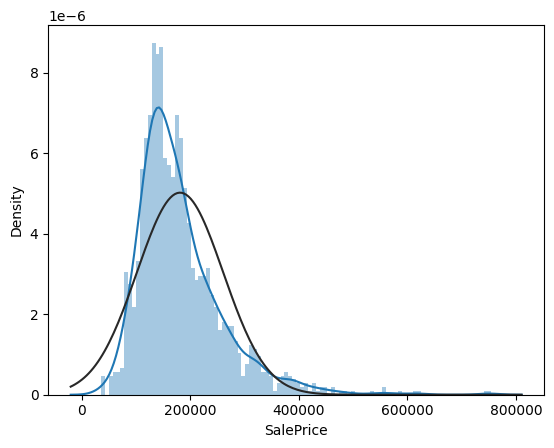

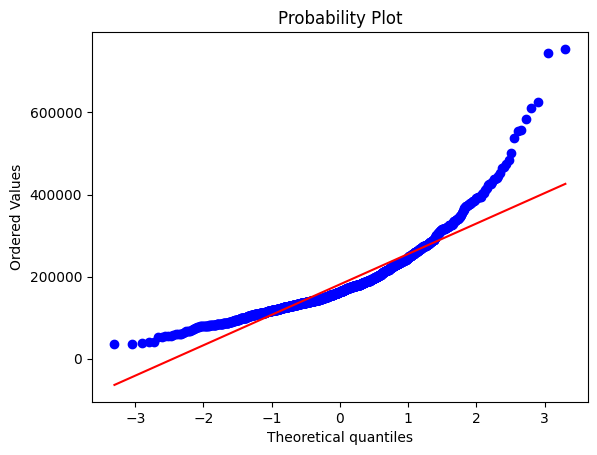

In [7]:
# Describe the target variable
y.describe()

# Plot the distribution of the target variable and show the skewness and kurtosis as well as compare it to a normal distribution
sns.distplot(y, fit=norm, bins=100, kde=True);
fig = plt.figure()
res = stats.probplot(y, plot=plt)

# Skewness and kurtosis
print("Skewness: %f" % y.skew())
print("Kurtosis: %f" % y.kurt())

In [8]:
# display_numerical_features(df=df_train_num, features=num_features, target=y)

- There are features that should be categorical but are numerical. We will convert them to categorical features:
    - MSSubClass
    - MoSold
    - YrSold
    - OverallQual
    - OverallCond
    - BsmtFullBath
    - BsmtHalfBath
    - FullBath
    - HalfBath
    - BedroomAbvGr
    - KitchenAbvGr
    - TotRmsAbvGrd
    - Fireplaces
    - GarageCars
    - PoolArea
    - MiscVal

In [9]:
# display_categorical_features(df=df_train_cat, features=cat_features, target=y)

## Part 1: Data Preprocessing and Feature Engineering
- Task: Handle missing values and categorize data in the dataset.
- Use techniques learned in Meeting 15 to deal with missing values and categories.
- Feature Engineering:
    - Implement fixed-width and quantile-based binning strategies from Meeting 16.
    - Document the rationale behind choosing specific bins and the impact on the dataset.


In [10]:
# Display missing values for numerical features in the training data
print("Missing values for numerical features in the training data:")
print(display_missing_values(df_train_num))
print()

# Display missing values for categorical features in the training data
print("Missing values for categorical features in the training data:")
print(display_missing_values(df_train_cat))
print()

# Display missing values for numerical features in the test data
print("Missing values for numerical features in the test data:")
display_missing_values(df_test_num)
print()

# Display missing values for categorical features in the test data
print("Missing values for categorical features in the test data:")
display_missing_values(df_test_cat)
print()

Missing values for numerical features in the training data:
             Missing Values  Percentage
LotFrontage             259       0.177
GarageYrBlt              81       0.055
MasVnrArea                8       0.005

Missing values for categorical features in the training data:
              Missing Values  Percentage
PoolQC                  1453       0.995
MiscFeature             1406       0.963
Alley                   1369       0.938
Fence                   1179       0.808
MasVnrType               872       0.597
FireplaceQu              690       0.473
GarageType                81       0.055
GarageCond                81       0.055
GarageQual                81       0.055
GarageFinish              81       0.055
BsmtFinType2              38       0.026
BsmtExposure              38       0.026
BsmtFinType1              37       0.025
BsmtQual                  37       0.025
BsmtCond                  37       0.025
Electrical                 1       0.001

Missing values for 

- Choose which strategy to use to impute each numerical feature:
    - 'LotFrontage': 'Zero'
    - 'MasVnrArea': 'mean' (will leave to the imputer)
    - 'GarageYrBlt': 'Zero'
- Choose which strategy to use to impute each categorical feature:
    - 'Alley': 'No alley access'
    - 'MasVnrType': 'No veneer'
    - 'BsmtQual': 'No Basement'
    - 'BsmtCond': 'No Basement'
    - 'BsmtExposure': 'No Basement'
    - 'BsmtFinType1': 'None'
    - 'BsmtFinType2': 'None'
    - 'Electrical': 'Most common value' (will leave to the imputer)
    - 'FireplaceQu': 'No Fireplace'
    - 'GarageType': 'No Garage'
    - 'GarageFinish': 'No Garage'
    - 'GarageQual': 'No Garage'
    - 'GarageCond': 'No Garage'
    - 'PoolQC': 'No Pool'
    - 'Fence': 'No Fence'
    - 'MiscFeature': 'None'

*** We do the imputation manually because in many of the features missing values actually mean lack of that feature.

In [11]:
# Impute missing values of numerical features based on the markdown above
df['LotFrontage'] = df['LotFrontage'].fillna(0)

df['YearBuilt'] = df['YearBuilt'].fillna(0)

In [12]:
# Impute missing values of categorical features based on the markdown above

# Find all missing value columns and put their names in a list
cat_features_with_missing = display_missing_values(df_train_cat).index.to_list()
cat_features_with_missing.remove('MiscFeature') # Remove 'MiscFeature' in order to impute separately

# Manually impute categorical features
impute_no_feature(df=df, feature_list=cat_features_with_missing)

df['MiscFeature'] = df['MiscFeature'].fillna('None')

## Part 2: Baseline Model Creation and Evaluation
- Baseline Model: Construct a baseline model using the Random Forest algorithm and the features engineered in Part 1.
- Evaluation:
    - Perform k-fold cross-validation.
    - Use default scoring and negative mean squared error metrics.
- Task: Plot and analyze the feature importance graph to understand the impact of each feature.


In [13]:
# Move suspected categorical features from the numerical list to the categorical
suspected_categorical = [
    'MSSubClass',
    'MoSold',
    'YrSold',
    'BsmtFullBath',
    'BsmtHalfBath',
    'FullBath',
    'HalfBath',
    'BedroomAbvGr',
    'KitchenAbvGr',
    'TotRmsAbvGrd',
    'Fireplaces',
    'GarageCars',
    'PoolArea',
    'MiscVal'
]

# Convert suspected categories to categorical in the training and testing data
num_features, cat_features = convert_to_categorical(
    df=df, 
    df_num=df_train_num, 
    df_cat=df_train_cat, 
    num_features=num_features, 
    cat_features=cat_features, 
    columns=suspected_categorical
    )

num_features_test, cat_features_test = convert_to_categorical(
    df=df_test, 
    df_num=df_test_num, 
    df_cat=df_test_cat, 
    num_features=num_features, 
    cat_features=cat_features, 
    columns=suspected_categorical
)

In [14]:
# Build the data pipeline
rf_pipeline = build_pipeline(numerical_columns=num_features, categorical_columns=cat_features)

# Remove target from base DataFrame
X = df.drop('SalePrice', axis=1)

# Fit the pipeline
rf_pipeline.fit(X, y)

# Cross validation
cross_validate_estimator(estimator=rf_pipeline, X=X, y=y, cv=5)

Cross-validation scores: [0.86766431 0.84364452 0.86822899 0.8790457  0.82686707], scores average: (0.8570901203571673, 'std: ', 0.019037606800775504)


Cross-validation scores: [7.32164367e+08 1.02736021e+09 9.98534096e+08 6.12736914e+08
 1.16092026e+09], scores average: (906343169.1293786, 'std: ', 202235839.42716604)


## Part 3: Categorical Feature Transformation and Analysis
- Feature Transformation:
    - Convert 'OverallQual' and 'GarageCars' into categorical features.
    - Analyze how this transformation affects feature importance.
- Sale Price Estimation:
    - Calculate the mean SalePrice per GrLivArea.
    - Create a new column estimating the apartment price (GrLivArea * mean SalePrice).
- Prediction and Kaggle Submission:
    - Predict prices on the test dataset using the new features.
    - Submit to Kaggle and document the score received.


## Part 4: Advanced Methods and Model Enhancement
- Custom Feature Engineering:
    - Calculate mean price per area for each quality group.
    - Use these values to create estimations based on apartment quality group and living area.
    - Explore and create additional custom features to enhance model performance.
    - Document the impact of these features on the model's accuracy.
- Kaggle Competition and Stacked Regression:
    - Integrate new features into the stacked regression notebook provided (link: Stacked Regressions Notebook).
    - Submit the updated model to Kaggle and report the new score.
